In [1]:
# libraries
import re
import numpy as np
import pandas as pd
from pymongo import MongoClient
from pprint import pprint as pp
from tqdm import tqdm

# Q1. Clean, manipulate, and structure data. The expected result is a well- designed dataset that complies with the specific approach of the chosen DBMS.

In order to use the pymongo we get connected to the localhost of MongoDB compass and access the git_issues collection of the DMS database. 

In [2]:
# let's connect to the localhost
client = MongoClient()

# See the available databases
print(client.database_names())

['DMS', 'admin', 'config', 'local', 'smm695']


/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_3840/2648176923.py:5: DeprecationWarning: database_names is deprecated. Use list_database_names instead.
  print(client.database_names())


In [3]:

# Connect to a database 
db = client.DMS

# collection
git_issues = db.git_issues

## Stats about the database
stats = db.command('collstats', 'git_issues')
# initial number of objects
in_objects = stats['count']
# intial collection size
in_size = round(stats['size']/10**6,2)

print('''
Basic stats of the Collection
=============================
Database: {}
------------
Collection: {}
------------
Number of object in Collection: {}
------------
Size of collection: {} MB
=============================
'''.format(db.name, git_issues.name, in_objects, in_size), flush=True)


Basic stats of the Collection
Database: DMS
------------
Collection: git_issues
------------
Number of object in Collection: 32329
------------
Size of collection: 142.51 MB



It can be seen that the git_issues collection contained **32.329 issue's** entries and has a size of **143.83 MB**. So now we will examine the structure of the given collection in order to find ways the reshape it into a more desirable format. 

## Examining the main issues' objects on the collection 

Based on the assumption that every issue will have a unique title we will examine the distinct values on the titles in all the documents of the collection.

In [4]:
# To see the distinct values of the main issue
titles = git_issues.distinct('title')
print('''
Number of object in Collection: {}
-----------
Number of main Issues: {}
'''.format(in_objects , len(titles)))


Number of object in Collection: 32329
-----------
Number of main Issues: 5400



It can be seen that the collection containes 5.400 unique issues which reflects only the 16 % of the total dataset. This is an indication that the data need to be restructured. 

In [5]:
# Find the schema of the collection from the 1st element
obj = git_issues.find_one()
print('Schema of the table')
print('===================')
for field in obj.keys():
    print(field, type(obj[field]) )
print('===================')


Schema of the table
_id <class 'bson.objectid.ObjectId'>
title <class 'str'>
state <class 'str'>
body <class 'str'>
user <class 'str'>
user_id <class 'str'>
repository <class 'NoneType'>
created_at <class 'datetime.datetime'>
updated_at <class 'datetime.datetime'>
closed_at <class 'datetime.datetime'>
assignees <class 'list'>
labels <class 'list'>
reactions <class 'list'>
n_comments <class 'int'>
closed_by <class 'str'>
comment_id <class 'int'>
comment_created_at <class 'datetime.datetime'>
comment_updated_at <class 'datetime.datetime'>
comment_user_id <class 'str'>
comment_user <class 'str'>
comment_text <class 'str'>
project <class 'str'>
total_reactions <class 'int'>


## Changing the reactions from array to count

We noticed that the reactions that each issue gets was had an array type and the main information in the array was multiple instances of the string '+1'. So we decided to replace this field with the count of those reactions.

In [6]:
# Exploring the reactions of the issues
print('''
For reactions:
==============
Unique values: {}
Number of +1: {}
Number of -1: {}
Number of confused: {}
NUmber of eyes: {}
Number of heart: {}
Number of hooray: {}
Number of laugh: {}
Number of rocket: {}
==============
'''.format(git_issues.distinct('reactions'), git_issues.count_documents({'reactions': {'$eq': '+1'}}),git_issues.count_documents({'reactions': {'$eq': '-1'}}),
git_issues.count_documents({'reactions': {'$eq': 'confused'}}),git_issues.count_documents({'reactions': {'$eq': 'eyes'}}),git_issues.count_documents({'reactions': {'$eq': 'heart'}}),
git_issues.count_documents({'reactions': {'$eq': 'hooray'}}),git_issues.count_documents({'reactions': {'$eq': 'laugh'}}),git_issues.count_documents({'reactions': {'$eq': 'rocket'}})))


For reactions:
Unique values: ['+1', '-1', 'confused', 'eyes', 'heart', 'hooray', 'laugh', 'rocket']
Number of +1: 3114
Number of -1: 101
Number of confused: 71
NUmber of eyes: 294
Number of heart: 277
Number of hooray: 153
Number of laugh: 55
Number of rocket: 92



In [7]:
# Change the type of reaction 
change =  git_issues.update_many({},[{'$set': {'total_reactions': {'$size': '$reactions'}}}])

print('''
Matched: {}
Modified: {}
'''.format(change.matched_count , change.modified_count))


Matched: 32329
Modified: 0



Here we examined the schema of a document in the collection in order to see if its fields has the apropriate format. 
Also we notices that in the document 2 group of information is present:
- Information about the issue
- Information about the comments which were posted under the same issue

## Combine the comments of each issue into an array

By exporing the dataset and by cross-validate the scraped information with the actual issues on Github we noticed that the document was created based on the comments in each issue. More specifically, the informations regarding the comments was different in every document, however the data regarding the issues under which the comments were posted remained the same for all the comments / documents assosiated with it. 

So we decide to reduce this repeated information and restructure documents at the collection based on each unique issue and create an array that will contain documents with each comment's information.

In order to do that we will create an aggregation pipeline in order to group the documents by title and the append all the information related to comments into an array under each unique issue.
Then we saved the output of this aggregation into a new collection called git_issues_fixed.

In [8]:
pipeline_issues = [
    {'$group': {
        '_id': '$title',
        'state': { '$first': '$state'},
        'body': { '$first': '$body'},
        'user': { '$first': '$user'},
        'user_id': { '$first': '$user_id'},
        'repository': { '$first': '$repository'},
        'created_at': { '$first': '$created_at'},
        'updated_at': { '$first': '$updated_at'},
        'closed_at': { '$first': '$closed_at'},
        'assignees': { '$first': '$assignees'},
        'labels': { '$first': '$labels'},
        'total_reactions': { '$first':'$total_reactions'},
        'reactions': { '$first': '$reactions'},
        'n_comments': { '$first': '$n_comments'},
        'closed_by': { '$first': '$closed_by'},
        'project': { '$first': '$project'},
        'comments':{
            '$push' : {'comment_id': '$comment_id', 'comment_created_at': '$comment_created_at',
                       'comment_updated_at':'$comment_updated_at', 'comment_user_id': '$comment_user_id',
                       'comment_user': '$comment_user', 'comment_text': '$comment_text' }
        }
    }},
    {'$out': {'db': 'DMS', 'coll': 'git_issues_fixed'}}
]

In [9]:
agr = git_issues.aggregate(pipeline_issues, allowDiskUse = True, bypassDocumentValidation = True )

In [10]:
## Stats about the database
stats = db.command('collstats', 'git_issues_fixed')
print('''
======================================
Initial size of the collection: {} MB
Initial number of ojects: {}
--------------------------------------
New size of the collection: {} MB
New number of objects: {}
======================================
'''.format(in_size, in_objects, round(stats['size']/10**6,2), stats['count']))


Initial size of the collection: 142.51 MB
Initial number of ojects: 32329
--------------------------------------
New size of the collection: 37.17 MB
New number of objects: 5400



It can be seen that after the restructuring of the information we manage to reduce both the size of collection by **74%** and the total number if documents from **32329** to **5400** by removing the reapeted fields regarding the main issue without loosing any information.

In [11]:
# Connecting to the restructured database
# collection
git_issues_fixed = db.git_issues_fixed

### Creating the organisations for git_issues

In [12]:
# Exploring the distinct project names
git_issues_fixed.distinct('project')

['pytorch', 'tensorflow']

In [13]:
# Creating the new field for the organisation appeared in the issues for consistancy
change_1 = git_issues_fixed.update_many({'project': 'tensorflow'},[{'$set': {'organisation': 'tensorflow'}}])
change_2 = git_issues_fixed.update_many({'project': 'pytorch'},[{'$set': {'organisation': 'pytorch'}}])

print('''
Matched: {}
Modified: {}
'''.format(change_1.matched_count , change_1.modified_count))

print('''
Matched: {}
Modified: {}
'''.format(change_2.matched_count , change_2.modified_count))


Matched: 5280
Modified: 5280


Matched: 120
Modified: 120



In [14]:
## Stats about the database
stats = db.command('collstats', 'git_issues_fixed')
print('''
======================================
New size of the collection: {} MB
New number of objects: {}
======================================
'''.format(round(stats['size']/10**6,2), stats['count']))


New size of the collection: 37.33 MB
New number of objects: 5400



## Working with the closed info

Then we examine the fields related with the main issue and more specifically the data regarding closing (resolving) of the issue. We so that all the issues in the collection was closed and we don't have any missing information regarding the date and the user who close it. So we decided to group them as a nested document and assigne them into the field called 'closed_info'. Then we excluded the state field.

In [15]:
# Inspecting the values of state
print('''
State's unique values: {}
Number of closed issues: {}
Number of 'closed_at': {}
Number of 'closed_by': {}
'''.format(git_issues_fixed.distinct('state'), git_issues_fixed.find({'state':'closed'}).count(),
 git_issues_fixed.find({'closed_at':{'$exists': True }}).count(), git_issues_fixed.find({'closed_by':{'$exists': True }}).count()))


State's unique values: ['closed']
Number of closed issues: 5400
Number of 'closed_at': 5400
Number of 'closed_by': 5400



/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_3840/120792990.py:7: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  '''.format(git_issues_fixed.distinct('state'), git_issues_fixed.find({'state':'closed'}).count(),
/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_3840/120792990.py:8: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  git_issues_fixed.find({'closed_at':{'$exists': True }}).count(), git_issues_fixed.find({'closed_by':{'$exists': True }}).count()))


In [16]:
# Creating a nested object with the closed info
change = git_issues_fixed.update_many({},[{'$set':{'closed_info': {'closed_at': '$closed_at', 'closed_by': '$closed_by'}}}])

print('''
Matched: {}
Modified: {}
'''.format(change.matched_count , change.modified_count))


Matched: 5400
Modified: 5400



In [17]:
#Deleted the dubplicated values
change = git_issues_fixed.update_many({}, {'$unset': {'state':'','closed_at':'','closed_by':''}})

print('''
Matched: {}
Modified: {}
'''.format(change.matched_count , change.modified_count))


Matched: 5400
Modified: 5400



# Working with git commits 

Now, in order to work with the collection containing the information for the commits of Pytorch and Tensorflow.

So we connected to the collection and explore its overal statistics allong with the schema of its fields. Based on this analysis we found that:
- The collection contains **60,334 documents**
- Occupy **7989.91 MB** of storage
- All its fields have their appropriate type

In [18]:
# Connect to a database 
db = client.DMS

# collection
git_commits = db.git

## Stats about the database
stats = db.command('collstats', 'git')
# initial number of objects
in_objects = stats['count']
# intial collection size
in_size = round(stats['size']/10**6,2)

print('''
Basic stats of the Collection
=============================
Database: {}
------------
Collection: {}
------------
Number of object in Collection: {}
------------
Size of collection: {} MB
=============================
'''.format(db.name, git_commits.name, in_objects, in_size), flush=True)


Basic stats of the Collection
Database: DMS
------------
Collection: git
------------
Number of object in Collection: 60996
------------
Size of collection: 8023.99 MB



In [19]:
# find the schema of the collection from the 1st element
obj = git_commits.find_one()
print('Schema of the table')
print('===================')
for field in obj.keys():
    print(field, type(obj[field]) )
print('===================')

Schema of the table
_id <class 'bson.objectid.ObjectId'>
hash <class 'str'>
msg <class 'str'>
author_name <class 'str'>
committer_name <class 'str'>
author_date <class 'datetime.datetime'>
author_timezone <class 'int'>
committer_date <class 'datetime.datetime'>
committer_timezone <class 'int'>
branches <class 'list'>
in_main_branch <class 'bool'>
merge <class 'bool'>
parents <class 'list'>
project_name <class 'str'>
deletions <class 'int'>
insertions <class 'int'>
lines <class 'int'>
files <class 'int'>
old_path <class 'str'>
new_path <class 'str'>
filename <class 'str'>
change_type <class 'str'>
diff <class 'str'>
diff_parsed <class 'dict'>
deleted_lines <class 'int'>
source_code <class 'str'>
source_code_before <class 'str'>
nloc <class 'int'>
complexity <class 'int'>
token_count <class 'int'>


### Ispecting the values of the fields

To have a better understanding about the values appeared at the collection's documents, we examine the number of unique values for all the documents. Our findings after the analysis were:
- There are 9 unique project names
- None of the files was merged
- More than one files were changed on each commit
- The old_path information are not the same with the new_path
- All the commints happend in the main / master branch
- We have 1102 commiters so each one of them is responsible for more than one commits
- We have **15124 unique hashes** which are the identifiers for each commit

In [20]:
# Inspecting the values of the following collection
print('Unique Project Names :', git_commits.distinct('project_name'), len(git_commits.distinct('project_name')))
print('--------------')
print('Unique merge values :',git_commits.distinct('merge'), len(git_commits.distinct('merge')))
print('Number of in_main_branch that contains True :', git_commits.find({'merge' : {'$eq': False}}).count())
print('--------------')
print('Unique file values :',git_commits.distinct('files'), len(git_commits.distinct('files')))
print('--------------')
print('Number of unique old_path:',len(git_commits.distinct('old_path')))
print('--------------')
print('Number of unique new_path:',len(git_commits.distinct('new_path')))
print('--------------')

Unique Project Names : ['audio', 'elastic', 'pytorch', 'serve', 'tensorflow', 'text', 'torchrec', 'vision', 'xla'] 9
--------------
Unique merge values : [False] 1


/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_3840/1262365007.py:5: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  print('Number of in_main_branch that contains True :', git_commits.find({'merge' : {'$eq': False}}).count())


Number of in_main_branch that contains True : 60996
--------------
Unique file values : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 56, 57, 59, 60, 61, 62, 63, 64, 67, 69, 70, 71, 72, 73, 74, 75, 78, 82, 83, 84, 94, 96, 100, 116, 117, 122, 126, 128, 130, 131, 136, 138, 147, 148, 153, 154, 157, 163, 181, 183, 188, 191, 195, 212, 228, 234, 235, 248, 355, 487, 1011] 102
--------------
Number of unique old_path: 15151
--------------
Number of unique new_path: 16170
--------------


In [21]:
print('--------------')
print('Number of unique committer_name:',len(git_commits.distinct('committer_name')))
print('--------------')
print('Number of unique author_name:',len(git_commits.distinct('author_name')))
print('--------------')
print('Unique in_main_branch values :',git_commits.distinct('in_main_branch'), len(git_commits.distinct('in_main_branch'))) 
print('Number of in_main_branch that contains True :', git_commits.find({'in_main_branch' : {'$eq': True}}).count())
print('--------------')
print('Unique branches : ', git_commits.distinct('branches'), len(git_commits.distinct('branches'))) # We can drop the column with the string because we have the in 'in_main_branch'
print('--------------')
print('Number of unique hash:',len(git_commits.distinct('hash')))  # The total documents in the collections are 60.996 so overlaping

--------------
Number of unique committer_name: 182
--------------
Number of unique author_name: 1102
--------------
Unique in_main_branch values : [True] 1


/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_3840/3065867356.py:7: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  print('Number of in_main_branch that contains True :', git_commits.find({'in_main_branch' : {'$eq': True}}).count())


Number of in_main_branch that contains True : 60996
--------------
Unique branches :  ['main', 'master'] 2
--------------
Number of unique hash: 15124


In [22]:
print('Number of unique parents:',len(git_commits.distinct('parents')))

Number of unique parents: 14561


In [23]:
#print('Number of unique source_code_before:',len(git_commits.distinct('source_code_before')))

In [24]:
# droping the braches field because all of the are on the main (or Master) branche and we get thin information from 'in_main_branch' field.

change = git_commits.update_many({}, {'$unset': {'branches':''} })

print('''
Matched: {}
Modified: {}
'''.format(change.matched_count , change.modified_count))


Matched: 60996
Modified: 60996



In [25]:
## Stats about the database
stats = db.command('collstats', 'git')
# intial collection size
round(stats['size']/10**6,2)

8022.23

## Examining the hashes

Commit hashes

The long string following the word commit is called the commit hash. It’s unique identifier generated by Git. Every commit has one, and I’ll show you what they’re used for shortly.

Note: The “commit hash” is sometimes called a Git commit “reference” or “SHA”.

Source: https://www.deployhq.com/git/viewing-previous-commits

In [26]:
hashes = git_commits.distinct('hash')

In [27]:
print(len(hashes))

15124


### Finding duplicates

Here we wanted to examine if we have duplicated information. In order to find them we grouped the documents by the following fields:
- Hash
- new_path
- old_path
Because this fields can identify the unique documents at the collection and then we found the ids for the duplicated instances in order to remove them.

In [28]:
pipeline_dupl =[
    {'$group': {
        '_id': {'hash': '$hash', 'new_path': '$new_path', 'old_path': '$old_path'},
        'uniqueIds': {'$addToSet': '$_id'},
        'count': {'$sum':1}
    }
    },

    {'$match': {'count':{'$gt':1}}},
    {'$sort': {'count':-1}}
]

In [29]:
dpl = git_commits.aggregate(pipeline_dupl)
print('Number of duplicates instances at the collection :', len(list(dpl)))

Number of duplicates instances at the collection : 325


In [30]:
dpl = git_commits.aggregate(pipeline_dupl)
dpl_id=[]
for d in dpl:
    for id in d['uniqueIds']:
        dpl_id.append(id)

In [31]:
print('Number of dublicates in the collection :', len(dpl_id))

Number of dublicates in the collection : 662


In [32]:
# Delete the duplicated documents that contained the duplicated IDs
change = git_commits.delete_many({'_id':{'$in': dpl_id}})

In [33]:
## Stats about the database
stats = db.command('collstats', 'git')

print('''
Basic stats of the Collection
=============================
Number of object in Collection: {}
------------
Size of collection: {} MB
=============================
'''.format(stats['count'], round(stats['size']/10**6,2)), flush=True)


Basic stats of the Collection
Number of object in Collection: 60334
------------
Size of collection: 7988.17 MB



## Combine the changes in each commit

By exporing the dataset and by cross-validate the scraped information with the actual commits on Github we noticed that the document was created based on the changes in different files that occured in the same commit. More specifically, the informations regarding the changes in each specific file was different in every document, however the data regarding the commit that stored all those changes remained the same for all the changes assosiated with it. 

So we decide to reduce this repeated information and restructure documents at the collection based on each unique hash and create an array that will contain documents with each changes's information as in the case of the issues' collection.

In order to do that we will create an aggregation pipeline in order to group the documents by hash and the append all the information related to file changes into an array under each unique commit.
Then we saved the output of this aggregation into a new collection called git_fixed.

In [34]:
pipeline_commits_final = [
    
    {'$group': {
        '_id': '$hash',
        'msg': { '$first': '$msg'},
        'hash': { '$first': '$hash'},
        'author_name': { '$first': '$author_name'},
        'committer_name': { '$first': '$committer_name'},
        'author_date': { '$first': '$author_date'},
        'author_timezone': { '$first': '$author_timezone'},
        'committer_date': { '$first': '$committer_date'},
        'committer_timezone': { '$first': '$committer_timezone'},
        'branches': { '$first': '$branches'},
        'in_main_branch': { '$first': '$in_main_branch'},
        'merge': { '$first': '$merge'},
        'parents': { '$first': '$parents'},
        'project_name': { '$first': '$project_name'},
        'deletions': { '$first': '$deletions'},
        'insertions': { '$first': '$insertions'},
        'lines': { '$first': '$lines'},
        'files': { '$first': '$files'},
        'change_type': { '$first': '$change_type'},
        'files_changes': {
            '$push' : {'old_path': '$old_path', 'new_path': '$new_path', 'diff': '$diff',
                        'deleted_lines': '$deleted_lines', 'filename':'$filename',
                        'diff_parsed': '$diff_parsed', 'complexity': '$complexity',
                        'nloc': '$nloc','source_code': '$source_code',
                        'source_code_before': '$source_code_before' ,'token_count':'$token_count'}
        }
    }
},

{
    '$project': {
        'msg': '$msg',
        'hash': '$hash',
        'author': {
            'author_name' : '$author_name',
            'author_date': '$author_date',
            'author_timezone': '$author_timezone'
        },
        'committer': {
            'committer_name': '$committer_name',
            'committer_date': '$committer_date',
            'committer_timezone': '$committer_timezone'
        },
        'branches': '$branches',
        'in_main_branch': '$in_main_branch',
        'merge': '$merge',
        'parents': '$parents',
        'project_name': '$project_name',
        'deletions': '$deletions',
        'insertions': '$insertions',
        'lines': '$lines',
        'files': '$files',
        'change_type': '$change_type',
        'files_changes': '$files_changes' 
    }
},

 {'$out': {'db': 'DMS', 'coll': 'git_fixed'}}]

In [35]:
agr = git_commits.aggregate(pipeline_commits_final, allowDiskUse = True, bypassDocumentValidation = True )

In [36]:
## Stats about the database
stats = db.command('collstats', 'git_fixed')

print('''
Basic stats of the Collection
=============================
Number of object in Collection: {}
------------
Size of collection: {} MB
=============================
'''.format(stats['count'], round(stats['size']/10**6,2)), flush=True)


Basic stats of the Collection
Number of object in Collection: 15124
------------
Size of collection: 7948.46 MB



### Creating the organisations for git_commits

In [37]:
git_fixed = db.git_fixed

In [38]:
# Exploring the distinct project names
git_fixed.distinct('project_name')

['audio',
 'elastic',
 'pytorch',
 'serve',
 'tensorflow',
 'text',
 'torchrec',
 'vision',
 'xla']

In [39]:
# Creating the new field for the organisation appeared in the issues for consistancy
change_1 = git_fixed.update_many({'project_name': 'tensorflow'},[{'$set': {'organisation': 'tensorflow'}}])
change_2 = git_fixed.update_many({'project_name': {'$in': ['audio', 'elastic', 'serve','pytorch', 'text', 'torchrec','vision','xla']}},[{'$set': {'organisation': 'pytorch'}}])

print('''
Matched: {}
Modified: {}
'''.format(change_1.matched_count , change_1.modified_count))

print('''
Matched: {}
Modified: {}
'''.format(change_2.matched_count , change_2.modified_count))


Matched: 9152
Modified: 9152


Matched: 5972
Modified: 5972



# Q2. Provide valuable descriptive insights. The expected result is a set of descriptive statistics that depicts some interesting trends or noteworthy data characteristics.

### Examining the number of files in the files_changes with the field files

In [40]:
files_valid = [
    {'$project': {'count': { '$size': '$files_changes'},
                  'files':'$files',
                   'difference': {'$subtract':['$files', { '$size': '$files_changes'}]}}},
    {'$match': {'difference':{'$gt':0}}}
]

temp = git_fixed.aggregate(files_valid)

print('The number of documents with different "files" number with the actual modified filers are the following')
print('=======================================================================================================')
print()
for element in temp:
    pp(element)

The number of documents with different "files" number with the actual modified filers are the following

{'_id': '1022443168b5fad55bbd03d087abf574c9d2e9df',
 'count': 116,
 'difference': 72,
 'files': 188}
{'_id': '2f099c7555ab41e55ddfd12ba3ed804e52894820',
 'count': 318,
 'difference': 169,
 'files': 487}
{'_id': '687c2267d4dfb69138483f90deb4d4f5921a2965',
 'count': 108,
 'difference': 379,
 'files': 487}
{'_id': 'a012216b960c5c31ca2a56a47da454d105764895',
 'count': 6,
 'difference': 4,
 'files': 10}
{'_id': 'a9b0a921d592b328e7e80a436ef065dadda5f01b',
 'count': 777,
 'difference': 234,
 'files': 1011}
{'_id': 'b0043072529b81276a69df29e00555333117646c',
 'count': 115,
 'difference': 73,
 'files': 188}
{'_id': 'd3bcba5f85f97ef273109924c695f33bf739e115',
 'count': 11,
 'difference': 3,
 'files': 14}


## For Github Issues

In [41]:
git_issues_fixed = db.git_issues_fixed

### Examining the dates that each issue posted

In [42]:
# Create the pipeline for the analysis
project = {'$project': {

        'title':1,
        'user_id':1,

        'created_year': {'$year': '$created_at'},
        'created_month': {'$month': '$created_at'},
        'created_hour': {'$hour': '$created_at'},
        
        'updated_year': {'$year':'$updated_at'},
        'updated_month': {'$month': '$updated_at'},
        'updated_hour': {'$hour': '$updated_at'},

        'closed_year': {'$year': '$closed_info.closed_at'},
        'closed_month': {'$month': '$closed_info.closed_at'},
        'closed_hour': {'$hour': '$closed_info.closed_at'}
        }
    }


# Regarding the date created
print('''
Analysis of Issues per Date
===========================
''')
year = git_issues_fixed.aggregate([project, { '$group': { '_id': '$created_year', 'Issues': {'$sum': 1}}}, {'$sort': {'_id':1}} ])
for element in year:
    pp(element)

print('------------')
month = git_issues_fixed.aggregate([project, { '$group': {'_id': '$created_month', 'Issues': {'$sum': 1} } }, {'$sort': {'_id':1}} ])
for element in month:
    pp(element)

print('------------')
ym = git_issues_fixed.aggregate([project, {'$group': {'_id': {'Year':'$created_year', 'Month':'$created_month'}, 'Issues': {'$sum': 1} } }, {'$sort': {'_id':1}} ])
for element in ym:
    pp(element)

# Regarding the time the issue posted
print('''
Analysis of Issues per Hour
===========================
''')
hours = git_issues_fixed.aggregate([project, { '$group': {'_id': '$created_month', 'Issues': {'$sum': 1} } }, {'$sort': {'_id':1}}])
for element in hours:
    pp(element)


Analysis of Issues per Date

{'Issues': 5, '_id': 2016}
{'Issues': 65, '_id': 2017}
{'Issues': 50, '_id': 2018}
{'Issues': 900, '_id': 2020}
{'Issues': 4380, '_id': 2021}
------------
{'Issues': 537, '_id': 1}
{'Issues': 494, '_id': 2}
{'Issues': 569, '_id': 3}
{'Issues': 478, '_id': 4}
{'Issues': 453, '_id': 5}
{'Issues': 367, '_id': 6}
{'Issues': 360, '_id': 7}
{'Issues': 460, '_id': 8}
{'Issues': 402, '_id': 9}
{'Issues': 416, '_id': 10}
{'Issues': 428, '_id': 11}
{'Issues': 436, '_id': 12}
------------
{'Issues': 2, '_id': {'Month': 8, 'Year': 2016}}
{'Issues': 1, '_id': {'Month': 9, 'Year': 2016}}
{'Issues': 1, '_id': {'Month': 10, 'Year': 2016}}
{'Issues': 1, '_id': {'Month': 11, 'Year': 2016}}
{'Issues': 2, '_id': {'Month': 1, 'Year': 2017}}
{'Issues': 6, '_id': {'Month': 2, 'Year': 2017}}
{'Issues': 3, '_id': {'Month': 3, 'Year': 2017}}
{'Issues': 3, '_id': {'Month': 4, 'Year': 2017}}
{'Issues': 5, '_id': {'Month': 5, 'Year': 2017}}
{'Issues': 3, '_id': {'Month': 6, 'Year': 20

### Analysis of the issue's labels

In [43]:
# Issues with the highest reactions - what sort of issues are they? 
pipeline_reactions = [
    {'$unwind': '$labels'},
    {'$group': {'_id':{'OS':'$organisation', 'Labels':'$labels'}, 'Total_reactions': {'$sum': '$total_reactions'}}},
    {'$sort': {'Total_reactions':-1}},
    {'$limit': 20}
]

print('''
Top 20 most reacted labels
==========================
''')
reactions = git_issues_fixed.aggregate(pipeline_reactions)
for element in reactions:
    pp(element)


Top 20 most reacted labels

{'Total_reactions': 363, '_id': {'Labels': 'triaged', 'OS': 'pytorch'}}
{'Total_reactions': 345,
 '_id': {'Labels': 'type:build/install', 'OS': 'tensorflow'}}
{'Total_reactions': 263, '_id': {'Labels': 'high priority', 'OS': 'pytorch'}}
{'Total_reactions': 241, '_id': {'Labels': 'TF 2.5', 'OS': 'tensorflow'}}
{'Total_reactions': 240, '_id': {'Labels': 'type:feature', 'OS': 'tensorflow'}}
{'Total_reactions': 232,
 '_id': {'Labels': 'stat:awaiting response', 'OS': 'tensorflow'}}
{'Total_reactions': 211, '_id': {'Labels': 'module: numpy', 'OS': 'pytorch'}}
{'Total_reactions': 153, '_id': {'Labels': 'type:bug', 'OS': 'tensorflow'}}
{'Total_reactions': 147, '_id': {'Labels': 'stalled', 'OS': 'tensorflow'}}
{'Total_reactions': 128,
 '_id': {'Labels': 'stat:awaiting tensorflower', 'OS': 'tensorflow'}}
{'Total_reactions': 128, '_id': {'Labels': 'triage review', 'OS': 'pytorch'}}
{'Total_reactions': 120, '_id': {'Labels': 'comp:keras', 'OS': 'tensorflow'}}
{'Total_r

In [44]:
# Issues with the highest comments 
pipeline_comments = [
    {'$unwind': '$labels'},
    {'$project': {'Comments': {'$size': '$comments'}, 'labels': 1, 'organisation':1}},
    {'$group': {'_id':{'OS':'$organisation', 'Labels':'$labels'}, 'Total_comments': {'$first': '$Comments'}}},
    {'$sort': {'Total_comments':-1}},
    {'$limit': 20}
]

print('''
Top 20 most reacted labels
==========================
''')
comments = git_issues_fixed.aggregate(pipeline_comments)
for element in comments:
    pp(element)


Top 20 most reacted labels

{'Total_comments': 47, '_id': {'Labels': 'module: docs', 'OS': 'pytorch'}}
{'Total_comments': 47, '_id': {'Labels': 'module: dataloader', 'OS': 'pytorch'}}
{'Total_comments': 47, '_id': {'Labels': 'high priority', 'OS': 'pytorch'}}
{'Total_comments': 37,
 '_id': {'Labels': 'module: memory usage', 'OS': 'pytorch'}}
{'Total_comments': 28, '_id': {'Labels': 'TF 1.15', 'OS': 'tensorflow'}}
{'Total_comments': 28, '_id': {'Labels': 'comp:grappler', 'OS': 'tensorflow'}}
{'Total_comments': 28,
 '_id': {'Labels': 'module: bc-breaking', 'OS': 'pytorch'}}
{'Total_comments': 26, '_id': {'Labels': 'module: cuda', 'OS': 'pytorch'}}
{'Total_comments': 25, '_id': {'Labels': 'needs reproduction', 'OS': 'pytorch'}}
{'Total_comments': 25,
 '_id': {'Labels': 'awaiting response (this tag is deprecated)',
         'OS': 'pytorch'}}
{'Total_comments': 21, '_id': {'Labels': 'module: cudnn', 'OS': 'pytorch'}}
{'Total_comments': 21, '_id': {'Labels': 'actionable', 'OS': 'pytorch'}}


In [45]:
# Number of issues per label
labels_pipe = [
    {'$unwind': '$labels'},
    {'$group': {'_id':{'Labels':'$labels','OS': '$organisation'} , 'Issues': {'$sum': 1}}},
    {'$sort': {'Issues':-1}},
    {'$limit': 20}
]
labels_number = git_issues_fixed.aggregate(labels_pipe)
# Extracting the top 20 labels 
top_labels =  [label['_id']['Labels'] for label in labels_number]
#Reapply the pipeline to visualise the results
labels_number = git_issues_fixed.aggregate(labels_pipe)
print('''Most frequent labels in the issues
==================================''')
for element in labels_number:
    pp(element)

Most frequent labels in the issues
{'Issues': 2395,
 '_id': {'Labels': 'stat:awaiting response', 'OS': 'tensorflow'}}
{'Issues': 1589, '_id': {'Labels': 'stalled', 'OS': 'tensorflow'}}
{'Issues': 1408, '_id': {'Labels': 'type:bug', 'OS': 'tensorflow'}}
{'Issues': 1407, '_id': {'Labels': 'cla: yes', 'OS': 'tensorflow'}}
{'Issues': 972, '_id': {'Labels': 'comp:keras', 'OS': 'tensorflow'}}
{'Issues': 794, '_id': {'Labels': 'comp:lite', 'OS': 'tensorflow'}}
{'Issues': 791, '_id': {'Labels': 'TF 2.4', 'OS': 'tensorflow'}}
{'Issues': 712, '_id': {'Labels': 'ready to pull', 'OS': 'tensorflow'}}
{'Issues': 702, '_id': {'Labels': 'type:build/install', 'OS': 'tensorflow'}}
{'Issues': 663, '_id': {'Labels': 'type:support', 'OS': 'tensorflow'}}
{'Issues': 477,
 '_id': {'Labels': 'stat:awaiting tensorflower', 'OS': 'tensorflow'}}
{'Issues': 446, '_id': {'Labels': 'size:XS', 'OS': 'tensorflow'}}
{'Issues': 429, '_id': {'Labels': 'TF 2.5', 'OS': 'tensorflow'}}
{'Issues': 421, '_id': {'Labels': 'comp:

In [46]:
# Finding the average reactions and days needed to close per top label 
labels_analysis_pipe = [
    {'$unwind': '$labels'},
    {'$match': {'labels': {'$in': top_labels}}},
    {'$project': {'labels': 1, 'total_reactions':1 ,
    'duration': { '$dateDiff': { 'startDate': "$created_at", 'endDate': "$closed_info.closed_at", 'unit': "day" } }}},
    {'$group': {'_id': '$labels', 'Average_reactions': {'$avg':'$total_reactions'},
    'Average_days_to_close':{'$avg': '$duration'}, 'Min_days_to_close': {'$min': '$duration'}, 'Max_days_to_close': {'$max': '$duration'}
    }}
]

labels_analysis = git_issues_fixed.aggregate(labels_analysis_pipe)
print('''Average reactions and days needed to close per top label
========================================================''')
for element in labels_analysis:
    pp(element)

Average reactions and days needed to close per top label
{'Average_days_to_close': 47.097345132743364,
 'Average_reactions': 0.12515802781289506,
 'Max_days_to_close': 496,
 'Min_days_to_close': 0,
 '_id': 'TF 2.4'}
{'Average_days_to_close': 56.57453027139875,
 'Average_reactions': 0.09686847599164927,
 'Max_days_to_close': 522,
 'Min_days_to_close': 0,
 '_id': 'stat:awaiting response'}
{'Average_days_to_close': 63.45738636363637,
 'Average_reactions': 0.10866477272727272,
 'Max_days_to_close': 496,
 'Min_days_to_close': 0,
 '_id': 'type:bug'}
{'Average_days_to_close': 38.892753623188405,
 'Average_reactions': 0.11014492753623188,
 'Max_days_to_close': 450,
 'Min_days_to_close': 0,
 '_id': 'size:M'}
{'Average_days_to_close': 73.55443675267463,
 'Average_reactions': 0.09251101321585903,
 'Max_days_to_close': 522,
 'Min_days_to_close': 7,
 '_id': 'stalled'}
{'Average_days_to_close': 19.84304932735426,
 'Average_reactions': 0.06502242152466367,
 'Max_days_to_close': 301,
 'Min_days_to_clo

## For Github Commits

In [47]:
git_fixed = db.git_fixed

### Examining the split of each Open Source into individual files

In [48]:
# Finding the total number of files per organisation
files_organisation_pipe = [{'$group': {'_id': '$organisation', 'Total_files': {'$sum':'$files'}}}]

# Applying the pipeline
files_organisation = git_fixed.aggregate(files_organisation_pipe)
print('''
Number of files per OS
======================
''')
for element in files_organisation:
    pp(element)


files_organisation_pipe_analytic = [{'$group': {'_id': {'OS':'$organisation', 'Project': '$project_name'}, 'Total_files': {'$sum':'$files'}}},
{'$sort':{'Total_files':-1}}]

# Applying the pipeline
files_organisation_analytic = git_fixed.aggregate(files_organisation_pipe_analytic)
print('''
Number of files per project on each OS
======================================
''')
for element in files_organisation_analytic:
    pp(element)


Number of files per OS

{'Total_files': 30627, '_id': 'pytorch'}
{'Total_files': 30641, '_id': 'tensorflow'}

Number of files per project on each OS

{'Total_files': 30641, '_id': {'OS': 'tensorflow', 'Project': 'tensorflow'}}
{'Total_files': 24103, '_id': {'OS': 'pytorch', 'Project': 'pytorch'}}
{'Total_files': 2055, '_id': {'OS': 'pytorch', 'Project': 'vision'}}
{'Total_files': 1484, '_id': {'OS': 'pytorch', 'Project': 'audio'}}
{'Total_files': 1159, '_id': {'OS': 'pytorch', 'Project': 'xla'}}
{'Total_files': 941, '_id': {'OS': 'pytorch', 'Project': 'serve'}}
{'Total_files': 628, '_id': {'OS': 'pytorch', 'Project': 'torchrec'}}
{'Total_files': 244, '_id': {'OS': 'pytorch', 'Project': 'text'}}
{'Total_files': 13, '_id': {'OS': 'pytorch', 'Project': 'elastic'}}


### Examining the dates that each commit posted

In [49]:
# Create the pipeline for the analysis
project = {'$project': {

        'title':1,
        'user_id':1,

        'created_year': {'$year': '$author.author_date'},
        'created_month': {'$month': '$author.author_date'},
        'created_hour': {'$hour': '$author.author_date'},
        }
    }


# Regarding the date created
print('''
Analysis of Commits per Year
===========================
''')
year = git_fixed.aggregate([project, { '$group': { '_id': '$created_year', 'Commits': {'$sum': 1}}}, {'$sort': {'_id':1}} ])
for element in year:
    pp(element)

# Regarding the time the commits posted
print('''
Analysis of Commits per Month
===============================
''')
month = git_fixed.aggregate([project, { '$group': {'_id': '$created_month', 'Commits': {'$sum': 1} } }, {'$sort': {'_id':1}} ])
for element in month:
    pp(element)

# Regarding the time the commits posted
print('''
Analysis of Commits per Month and Year
===============================
''')
ym = git_fixed.aggregate([project, {'$group': {'_id': {'Year':'$created_year', 'Month':'$created_month'}, 'Commits': {'$sum': 1} } }, {'$sort': {'_id':1}} ])
for element in ym:
    pp(element)

# Regarding the time the commits posted
print('''
Analysis of Commits per Hour
===========================
''')
hours = git_fixed.aggregate([project, { '$group': {'_id': '$created_month', 'Commits': {'$sum': 1} } }, {'$sort': {'_id':1}}])
for element in hours:
    pp(element)


Analysis of Commits per Year

{'Commits': 2, '_id': 2020}
{'Commits': 15122, '_id': 2021}

Analysis of Commits per Month

{'Commits': 1, '_id': 1}
{'Commits': 7, '_id': 3}
{'Commits': 3, '_id': 4}
{'Commits': 19, '_id': 5}
{'Commits': 75, '_id': 6}
{'Commits': 2542, '_id': 7}
{'Commits': 2636, '_id': 8}
{'Commits': 2377, '_id': 9}
{'Commits': 2885, '_id': 10}
{'Commits': 2419, '_id': 11}
{'Commits': 2160, '_id': 12}

Analysis of Commits per Month and Year

{'Commits': 2, '_id': {'Month': 11, 'Year': 2020}}
{'Commits': 1, '_id': {'Month': 1, 'Year': 2021}}
{'Commits': 7, '_id': {'Month': 3, 'Year': 2021}}
{'Commits': 3, '_id': {'Month': 4, 'Year': 2021}}
{'Commits': 19, '_id': {'Month': 5, 'Year': 2021}}
{'Commits': 75, '_id': {'Month': 6, 'Year': 2021}}
{'Commits': 2542, '_id': {'Month': 7, 'Year': 2021}}
{'Commits': 2636, '_id': {'Month': 8, 'Year': 2021}}
{'Commits': 2377, '_id': {'Month': 9, 'Year': 2021}}
{'Commits': 2885, '_id': {'Month': 10, 'Year': 2021}}
{'Commits': 2417, '_id

In [50]:
# Create a dataframe with the timeseries data
month = git_fixed.aggregate([project, { '$group': {'_id': '$created_month', 'Commits': {'$sum': 1} } }, {'$sort': {'_id':1}} ])
months = [element for element in month]
month = [i['_id'] for i in months]
commits = [i['Commits'] for i in months]
df_month = pd. DataFrame({'Months': month, 'Commits': commits})

### Examining the contribution of each author and committer

In [51]:
# Frequency of commits by each author
pipeline_author = [
    {'$group': {
        '_id': '$author.author_name',
        'commits' : {'$sum':1} 
    }},
    {'$sort': {'commits':-1}},
    {'$limit': 20}]

print('''
Analysis of Commits per Hour
===========================
''')
# Applying the pipeline
authors = git_fixed.aggregate(pipeline_author)
for element in authors:
    pp(element)


Analysis of Commits per Hour

{'_id': 'A. Unique TensorFlower', 'commits': 3208}
{'_id': 'Mihai Maruseac', 'commits': 266}
{'_id': 'Nikita Shulga', 'commits': 207}
{'_id': 'Mehdi Amini', 'commits': 185}
{'_id': 'Samuel Marks', 'commits': 176}
{'_id': 'Peter Bell', 'commits': 147}
{'_id': 'Adrian Kuegel', 'commits': 145}
{'_id': 'moto', 'commits': 145}
{'_id': 'Jane Xu', 'commits': 129}
{'_id': 'Scott Wolchok', 'commits': 128}
{'_id': 'George Karpenkov', 'commits': 127}
{'_id': 'Philip Meier', 'commits': 127}
{'_id': 'Raman Sarokin', 'commits': 116}
{'_id': 'Rohan Varma', 'commits': 115}
{'_id': 'Eli Uriegas', 'commits': 106}
{'_id': 'Vasilis Vryniotis', 'commits': 97}
{'_id': 'Jerry Zhang', 'commits': 96}
{'_id': 'Faizan Muhammad', 'commits': 94}
{'_id': 'Terry Heo', 'commits': 93}
{'_id': 'Christian Sigg', 'commits': 88}


In [52]:
# Frequency of commits by each committer
pipeline_commiter = [
    {'$group': {
        '_id': '$committer.committer_name',
        'commits' : {'$sum':1} 
    }},
    {'$sort': {'commits':-1}},
    {'$limit': 20}]

# Applying the pipeline
authors = git_fixed.aggregate(pipeline_commiter)
for element in authors:
    pp(element)

{'_id': 'TensorFlower Gardener', 'commits': 8081}
{'_id': 'Facebook GitHub Bot', 'commits': 4690}
{'_id': 'GitHub', 'commits': 1035}
{'_id': 'Samuel Marks', 'commits': 175}
{'_id': 'jagadeesh', 'commits': 86}
{'_id': 'lxning', 'commits': 71}
{'_id': 'Frederic Bastien', 'commits': 53}
{'_id': 'Mark Saroufim', 'commits': 50}
{'_id': "Jonas Eschle 'Mayou36", 'commits': 39}
{'_id': 'Nikhil Kulkarni', 'commits': 38}
{'_id': 'Yong Tang', 'commits': 34}
{'_id': 'Ben Barsdell', 'commits': 33}
{'_id': 'Shrinath Suresh', 'commits': 28}
{'_id': 'Thibaut Goetghebuer-Planchon', 'commits': 25}
{'_id': 'Hamid Shojanazeri', 'commits': 23}
{'_id': 'Kaixi Hou', 'commits': 21}
{'_id': 'Rob Suderman', 'commits': 19}
{'_id': 'Ubuntu', 'commits': 19}
{'_id': 'Vignesh Kothapalli', 'commits': 19}
{'_id': 'feiwen.zfw', 'commits': 17}


# Q3. [optional] Perform an insightful data analysis. For example, you can analyse the modularity of the source code or the features of issues getting the community’s attention. You may want to skim through the reference list provided to get some inspiration.

In [1]:
# loading the libraries

import pyspark

#to create a spark session object
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import size
from pyspark.sql.functions import corr
import pyspark.sql.functions as F
from pyspark.sql.functions import month

# to create a spark context object
from pyspark.sql.functions import *
from pyspark.sql.types import *

# to create a spark dataframe object
from pyspark import SparkContext
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

# functions
import pyspark.sql.functions as F

# import datetime 
from datetime import date as dt

In [2]:
print(pyspark.__version__)

3.3.0


# Loading the git_issues_fixed data

In [3]:
# add path to Mongo
spark_mongo_issues = SparkSession \
    .builder \
    .appName("git_issues_fixed") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/DMS.git_issues_fixed") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/DMS.git_issues_fixed") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()

:: loading settings :: url = jar:file:/Users/georgekalfas/opt/anaconda3/envs/dms/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/georgekalfas/.ivy2/cache
The jars for the packages stored in: /Users/georgekalfas/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-511edc66-aa10-48a8-aff6-549a906b03d5;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 319ms :: artifacts dl 18ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            

22/07/22 04:28:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/22 04:28:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
spark_mongo_issues

In [5]:
# load data from MongoDB
df_issues = spark_mongo_issues.read.format("mongo").load()

df_issues.printSchema()

root
 |-- _id: string (nullable = true)
 |-- assignees: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- body: string (nullable = true)
 |-- closed_info: struct (nullable = true)
 |    |-- closed_at: timestamp (nullable = true)
 |    |-- closed_by: string (nullable = true)
 |-- comments: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- comment_id: integer (nullable = true)
 |    |    |-- comment_created_at: timestamp (nullable = true)
 |    |    |-- comment_updated_at: timestamp (nullable = true)
 |    |    |-- comment_user_id: string (nullable = true)
 |    |    |-- comment_user: string (nullable = true)
 |    |    |-- comment_text: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- labels: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- n_comments: integer (nullable = true)
 |-- organisation: string (nullable = true)
 |-- project: string (nullable = true)
 |-- reacti

In [6]:
# have a look on the descriptive statistics
df_issues.describe().show()

+-------+--------------------+----------------------------------+-----------------+------------+----------+-------------------+--------------------+--------------------+
|summary|                 _id|                              body|       n_comments|organisation|   project|    total_reactions|                user|             user_id|
+-------+--------------------+----------------------------------+-----------------+------------+----------+-------------------+--------------------+--------------------+
|  count|                5400|                              5321|             5400|        5400|      5400|               5400|                5400|                5400|
|   mean|4.354477945535333...|                              null|5.899629629629629|        null|      null|0.36796296296296294|1.185052975241176...|                null|
| stddev|7.536610993917221E12|                              null| 5.80656262549959|        null|      null|  6.494528131124699|3.908602612961585E10|  

In [7]:
# Inspecting the columns of the pyspark object
df_issues.columns

['_id',
 'assignees',
 'body',
 'closed_info',
 'comments',
 'created_at',
 'labels',
 'n_comments',
 'organisation',
 'project',
 'reactions',
 'repository',
 'total_reactions',
 'updated_at',
 'user',
 'user_id']

## Pre - processing for visualising issue urgency and level of attention

In [8]:
# have a look under the 'files' column
df_issues.select('_id', 'total_reactions', size('comments').alias('num_comments')).show()

+--------------------+---------------+------------+
|                 _id|total_reactions|num_comments|
+--------------------+---------------+------------+
|Cant dynamically ...|              0|           3|
|same issue with C...|              0|           3|
|Prediction depend...|              0|           4|
|Better performanc...|              0|          14|
|False out of reso...|              0|           5|
|Tensorflow 2.4  C...|              1|          24|
|Tensorflow 2.3.0 ...|              0|           8|
|Bazel build fails...|              0|           2|
|"Error: Found an ...|              0|          11|
|tensorflow lite o...|              0|          29|
|RTX 3090 Cuda 10....|              0|          37|
|tf.keras.Sequenti...|              6|          46|
|Slowdown training...|              1|          17|
|XLA compilation b...|              0|           7|
|backward(create_g...|              1|          37|
|micro: port op SP...|              0|           2|
|How to use 

In [9]:
# Finding the difference between created_at and closed_at dates
difference_df = df_issues.withColumn("date_diff", F.datediff(F.col('closed_info.closed_at'), F.col('created_at')))

In [10]:
# difference_df.select('_id', 'date_diff').show()
difference_df.select('_id', 'total_reactions', 'date_diff',size('comments').alias('num_comments')).show()

+--------------------+---------------+---------+------------+
|                 _id|total_reactions|date_diff|num_comments|
+--------------------+---------------+---------+------------+
|Cant dynamically ...|              0|       16|           3|
|same issue with C...|              0|       18|           3|
|Prediction depend...|              0|       16|           4|
|Better performanc...|              0|     1181|          14|
|False out of reso...|              0|        4|           5|
|Tensorflow 2.4  C...|              1|        3|          24|
|Tensorflow 2.3.0 ...|              0|      302|           8|
|Bazel build fails...|              0|        1|           2|
|"Error: Found an ...|              0|        7|          11|
|tensorflow lite o...|              0|      194|          29|
|RTX 3090 Cuda 10....|              0|       23|          37|
|tf.keras.Sequenti...|              6|      384|          46|
|Slowdown training...|              1|      359|          17|
|XLA com

In [11]:
# converting into a dataframe for visualisation purposes
difference_df_df = difference_df.select('_id', 'total_reactions', 'date_diff',size('comments').alias('num_comments')).toPandas()

## Visualisation

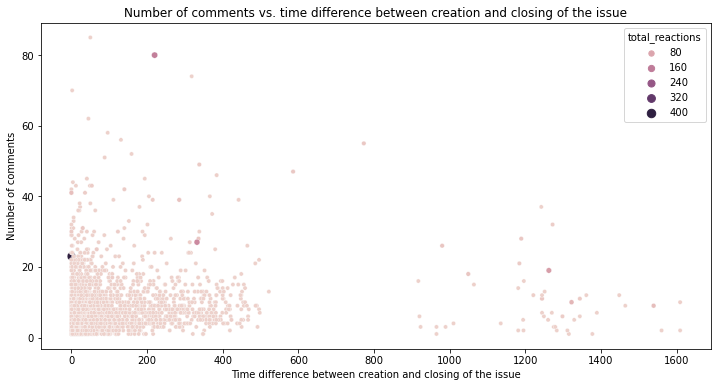

In [12]:
# creating the figure
plt.figure(figsize=(12,6))
sns.scatterplot( x=difference_df_df['date_diff'], y=difference_df_df['num_comments'], size=difference_df_df['total_reactions']+1, hue = difference_df_df['total_reactions']+1)

# adding title and labels
plt.title('Number of comments vs. time difference between creation and closing of the issue')
plt.xlabel('Time difference between creation and closing of the issue')
plt.ylabel('Number of comments')

# populate the figure
plt.show()

## Loading the git_fixed data

In [25]:
# add path to Mongo
spark_mongo_fixed = SparkSession \
    .builder \
    .appName("Git_fixed_data") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/DMS.git_fixed") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/DMS.git_fixed") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()

In [12]:
spark_mongo_fixed 

In [13]:
# load data from MongoDB
df_fixed = spark_mongo_fixed.read.format("mongo").load()

df_fixed.printSchema()

root
 |-- _id: string (nullable = true)
 |-- author: struct (nullable = true)
 |    |-- author_name: string (nullable = true)
 |    |-- author_date: timestamp (nullable = true)
 |    |-- author_timezone: integer (nullable = true)
 |-- branches: void (nullable = true)
 |-- change_type: string (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- committer_name: string (nullable = true)
 |    |-- committer_date: timestamp (nullable = true)
 |    |-- committer_timezone: integer (nullable = true)
 |-- deletions: integer (nullable = true)
 |-- files: integer (nullable = true)
 |-- files_changes: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- complexity: integer (nullable = true)
 |    |    |-- deleted_lines: integer (nullable = true)
 |    |    |-- diff: string (nullable = true)
 |    |    |-- diff_parsed: struct (nullable = true)
 |    |    |    |-- added: array (nullable = true)
 |    |    |    |    |-- element: array (containsNull = 

## Pre - processing

In [14]:
#  have a look on the descriptive statistics
df_fixed.describe().show()

+-------+--------------------+-----------+-----------------+------------------+--------------------+------------------+------------------+--------------------+------------+------------+
|summary|                 _id|change_type|        deletions|             files|                hash|        insertions|             lines|                 msg|organisation|project_name|
+-------+--------------------+-----------+-----------------+------------------+--------------------+------------------+------------------+--------------------+------------+------------+
|  count|               15124|      15124|            15124|             15124|               15124|             15124|             15124|               15124|       15124|       15124|
|   mean|                null|       null|83.84567574715683|  4.05104469717006|                null|126.73426342237504|210.57993916953188|                null|        null|        null|
| stddev|                null|       null|1129.970536429563|14.3751987

In [15]:
# checking the columns names
df_fixed.columns

['_id',
 'author',
 'branches',
 'change_type',
 'committer',
 'deletions',
 'files',
 'files_changes',
 'hash',
 'in_main_branch',
 'insertions',
 'lines',
 'merge',
 'msg',
 'organisation',
 'parents',
 'project_name']

In [16]:
# have a look under the 'files' column
df_fixed.select('files_changes').show()

+--------------------+
|       files_changes|
+--------------------+
|[{123, 1, @@ -237...|
|[{39, 0, @@ -28,6...|
|[{18, 1, @@ -86,1...|
|[{366, 1, @@ -135...|
|[{28, 4, @@ -281,...|
|[{null, 0, @@ -57...|
|[{null, 8, @@ -18...|
|[{2, 0, @@ -0,0 +...|
|[{26, 14, @@ -22,...|
|[{55, 2, @@ -257,...|
|[{123, 0, @@ -109...|
|[{null, 2, @@ -4,...|
|[{null, 1, @@ -33...|
|[{71, 30, @@ -382...|
|[{62, 4, @@ -102,...|
|[{null, 1, @@ -91...|
|[{33, 0, @@ -311,...|
|[{26, 46, @@ -71,...|
|[{178, 16, @@ -33...|
|[{1001, 4, @@ -57...|
+--------------------+
only showing top 20 rows



In [17]:
# exctracting from 'files_changes' column and parsing into lists for every one of the: 'deleted_lines', 'nloc', 'complexity', 'token_count'
deleted_lines = df_fixed.select('files_changes.deleted_lines').rdd.map(lambda x: x[0]).collect()
nloc = df_fixed.select('files_changes.nloc').rdd.map(lambda x: x[0]).collect()
complexity = df_fixed.select('files_changes.complexity').rdd.map(lambda x: x[0]).collect()
token_count = df_fixed.select('files_changes.token_count').rdd.map(lambda x: x[0]).collect()

22/07/22 05:28:29 WARN connection: Got socket exception on connection [connectionId{localValue:54, serverValue:99}] to 127.0.0.1:27017. All connections to 127.0.0.1:27017 will be closed.


In [27]:
# checking the length of the lists before adding them into a dataframe
print(len(deleted_lines))
print(len(nloc))
print(len(complexity))
print(len(token_count))

15124
15124
15124
15124


In [28]:
# extracting the list of lists and have one common list for every column
deleted_lines_list = [item for sublist in deleted_lines for item in sublist]
nloc_list = [item for sublist in nloc for item in sublist]
complexity_list = [item for sublist in complexity for item in sublist]
token_count_list = [item for sublist in token_count for item in sublist]

In [29]:
# creating a pandas dataframe with the lists
df_fixed_pandas = pd.DataFrame({'deleted_lines': deleted_lines_list, 'nloc': nloc_list, 'complexity': complexity_list, 'token_count': token_count_list})

In [30]:
# filling the missing values with 0
df_fixed_pandas.fillna(0, inplace=True)

In [31]:
# converting the values into integers
df_fixed_pandas['deleted_lines'] = df_fixed_pandas['deleted_lines'].astype(int)
df_fixed_pandas['nloc'] = df_fixed_pandas['nloc'].astype(int)
df_fixed_pandas['complexity'] = df_fixed_pandas['complexity'].astype(int)
df_fixed_pandas['token_count'] = df_fixed_pandas['token_count'].astype(int)

In [32]:
# converting pandas dataframe into spark dataframe
df_fixed_spark = spark_mongo_fixed.createDataFrame(df_fixed_pandas)

In [33]:
# visualising the spark dataframe
df_fixed_spark.show()

+-------------+----+----------+-----------+
|deleted_lines|nloc|complexity|token_count|
+-------------+----+----------+-----------+
|            1| 597|       123|       2876|
|            0| 249|        39|       1698|
|            1|  87|        18|        547|
|            1|1428|       366|      10094|
|            1|3342|        89|      26511|
|            4|5359|       234|      32887|
|            7|3183|       642|      20451|
|            4| 234|        28|       1878|
|            4| 199|        32|       1482|
|            1| 473|        94|       4181|
|            9| 249|        16|       3850|
|            0|  90|        11|        628|
|            0|   0|         0|          0|
|            0|   0|         0|          0|
|            0|   0|         0|          0|
|            0|   0|         0|          0|
|            0|   0|         0|          0|
|            1|   0|         0|          0|
|            8|   0|         0|          0|
|            0|  54|         3| 

## Checking correlations between the variables

In [34]:
# Checking for correlations 
df_fixed_spark.select(corr('complexity','nloc')).show()
df_fixed_spark.select(corr('complexity','deleted_lines')).show()
df_fixed_spark.select(corr('deleted_lines','token_count')).show()
df_fixed_spark.select(corr('complexity','token_count')).show()
df_fixed_spark.select(corr('nloc','token_count')).show()

+----------------------+
|corr(complexity, nloc)|
+----------------------+
|    0.9864208642916371|
+----------------------+

+-------------------------------+
|corr(complexity, deleted_lines)|
+-------------------------------+
|            0.07681656292786182|
+-------------------------------+

+--------------------------------+
|corr(deleted_lines, token_count)|
+--------------------------------+
|             0.07007489507690078|
+--------------------------------+

+-----------------------------+
|corr(complexity, token_count)|
+-----------------------------+
|           0.9646755632756743|
+-----------------------------+

+-----------------------+
|corr(nloc, token_count)|
+-----------------------+
|     0.9809395241513935|
+-----------------------+



## Visualisations of the data

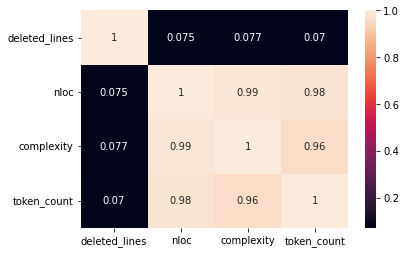

In [35]:
# visualising heatmap of the pandas dataframe
plt.Figure(figsize=(8,8))
sns.heatmap(df_fixed_pandas.corr(), annot=True)

# populate the figure
plt.show()

/Users/georgekalfas/opt/anaconda3/envs/dms/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/georgekalfas/opt/anaconda3/envs/dms/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


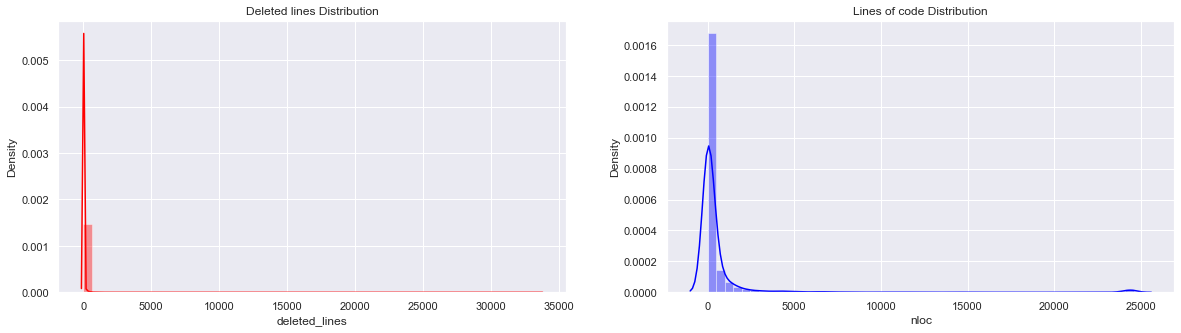

In [36]:
# distribution plot of the pandas dataframe
sns.set(rc={'figure.figsize': (20, 5)})
ax = plt.subplot(1, 2, 1)
ax1 = plt.subplot(1, 2, 2)

# creating the figures
sns.distplot(df_fixed_pandas['deleted_lines'], ax = ax, color = 'red')
sns.distplot(df_fixed_pandas['nloc'], ax = ax1, color = 'blue')

# labels and titles
ax.set_title('Deleted lines Distribution')
ax1.set_title('Lines of code Distribution')

# populate the figure
plt.show()

/Users/georgekalfas/opt/anaconda3/envs/dms/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/georgekalfas/opt/anaconda3/envs/dms/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


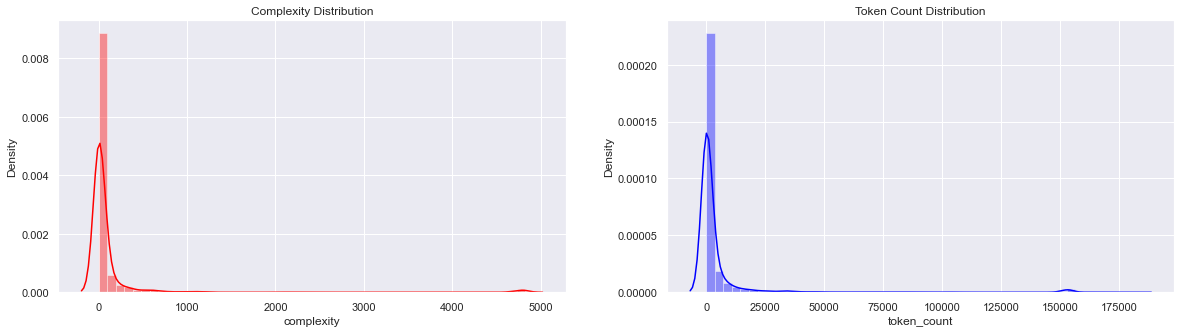

In [37]:
# distribution plot of the pandas dataframe
sns.set(rc={'figure.figsize': (20, 5)})
ax = plt.subplot(1, 2, 1)
ax1 = plt.subplot(1, 2, 2)

# creating the figures
sns.distplot(df_fixed_pandas['complexity'], ax = ax, color = 'red')
sns.distplot(df_fixed_pandas['token_count'], ax = ax1, color = 'blue')

# labels and titles
ax.set_title('Complexity Distribution')
ax1.set_title('Token Count Distribution')

# populate the figure
plt.show()

In [ ]:
# Extracting the month from author_date
committer_date = df_fixed.withColumn('month',month('author.author_date'))


In [ ]:
committer_date.select("month").show()

+-----+
|month|
+-----+
|   10|
|    8|
|   10|
|    9|
|   12|
|    8|
|    7|
|    9|
|    7|
|   12|
|   11|
|    8|
|    8|
|   10|
|    9|
|   10|
|   12|
|   12|
|   10|
|    8|
+-----+
only showing top 20 rows



In [ ]:
# Find the number of commits per month
committer_date.groupBy("month").count().show(truncate=False)

+-----+-----+
|month|count|
+-----+-----+
|8    |2632 |
|10   |2906 |
|12   |2173 |
|9    |2360 |
|7    |2543 |
|11   |2407 |
|6    |72   |
|5    |19   |
|1    |2    |
|3    |7    |
|4    |3    |
+-----+-----+



In [ ]:
# Transform it into a dataframe
committer_date_pd = pd.DataFrame(committer_date.groupBy("month").count().toPandas())

In [ ]:
#short the dataframe based on month
committer_date_pd.sort_values(by=['month'], ascending=True).head(10)

,month,count
8,1,2
9,3,7
10,4,3
7,5,19
6,6,72
3,7,2543
2,8,2632
1,9,2360
4,10,2906
5,11,2407


In [ ]:
committer_date_pd.reset_index(drop=True, inplace=True)


In [ ]:
import plotly.express as px

fig = px.line(x=committer_date_pd["month"], y=committer_date_pd["count"], title="Commits by Month",
             labels=dict(x="month", y="count", color="Time Period"))
fig.add_bar(x=committer_date_pd["month"], y=committer_date_pd["count"], name="Month")
fig.show()

## Linear regression based on the complexity

#### Pre - processing

In [38]:
assembler = VectorAssembler(inputCols=['deleted_lines', 'nloc', 'token_count'], outputCol='features')

In [39]:
output = assembler.transform(df_fixed_spark)

In [40]:
output.select("features","complexity").show()

+--------------------+----------+
|            features|complexity|
+--------------------+----------+
|  [1.0,597.0,2876.0]|       123|
|  [0.0,249.0,1698.0]|        39|
|    [1.0,87.0,547.0]|        18|
|[1.0,1428.0,10094.0]|       366|
|[1.0,3342.0,26511.0]|        89|
|[4.0,5359.0,32887.0]|       234|
|[7.0,3183.0,20451.0]|       642|
|  [4.0,234.0,1878.0]|        28|
|  [4.0,199.0,1482.0]|        32|
|  [1.0,473.0,4181.0]|        94|
|  [9.0,249.0,3850.0]|        16|
|    [0.0,90.0,628.0]|        11|
|           (3,[],[])|         0|
|           (3,[],[])|         0|
|           (3,[],[])|         0|
|           (3,[],[])|         0|
|           (3,[],[])|         0|
|       [1.0,0.0,0.0]|         0|
|       [8.0,0.0,0.0]|         0|
|    [0.0,54.0,356.0]|         3|
+--------------------+----------+
only showing top 20 rows



In [41]:
final_data = output.select("features","complexity")

In [42]:
#Split the train and test data into 70/30 ratio
train_data,test_data = final_data.randomSplit([0.7,0.3])

## Training the linear model

In [43]:
lr = LinearRegression(labelCol='complexity')

In [44]:
lrModel = lr.fit(train_data)

22/07/22 05:59:13 WARN Instrumentation: [a8d13ae6] regParam is zero, which might cause numerical instability and overfitting.


22/07/22 05:59:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/07/22 05:59:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/07/22 05:59:16 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [45]:
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [0.004795082849264832,0.19465561918302265,-0.0008955488321613928] Intercept: -11.062499383061589


In [46]:
#Evaluate the results with the test data
test_results_lr = lrModel.evaluate(test_data)

print("RMSE: {}".format(test_results_lr.rootMeanSquaredError))
print("MSE: {}".format(test_results_lr.meanSquaredError))
print("R2: {}".format(test_results_lr.r2))

RMSE: 91.24205183414247
MSE: 8325.112022904343
R2: 0.9779852043746878


In [47]:
summary = lrModel.summary
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("T Values: " + str(summary.tValues))
print("P Values: " + str(summary.pValues))

Coefficient Standard Errors: [0.00116593774197845, 0.0007973083006335536, 0.0001190413265633078, 0.4887790016733533]
T Values: [4.1126405610030075, 244.14096658512932, -7.523007832789294, -22.6329268343949]
P Values: [3.91898459426443e-05, 0.0, 5.46229728115577e-14, 0.0]


## Generalized Linear Regression

In [48]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(family="poisson", maxIter=100, labelCol="complexity", featuresCol="features", link="log")

In [49]:
glrModel = glr.fit(train_data)

22/07/22 05:59:20 WARN Instrumentation: [fd2a5e78] regParam is zero, which might cause numerical instability and overfitting.


22/07/22 05:59:21 WARN Instrumentation: [fd2a5e78] regParam is zero, which might cause numerical instability and overfitting.
22/07/22 05:59:21 WARN Instrumentation: [fd2a5e78] regParam is zero, which might cause numerical instability and overfitting.
22/07/22 05:59:22 WARN Instrumentation: [fd2a5e78] regParam is zero, which might cause numerical instability and overfitting.
22/07/22 05:59:22 WARN Instrumentation: [fd2a5e78] regParam is zero, which might cause numerical instability and overfitting.
22/07/22 05:59:22 WARN Instrumentation: [fd2a5e78] regParam is zero, which might cause numerical instability and overfitting.
22/07/22 05:59:23 WARN Instrumentation: [fd2a5e78] regParam is zero, which might cause numerical instability and overfitting.
22/07/22 05:59:23 WARN Instrumentation: [fd2a5e78] regParam is zero, which might cause numerical instability and overfitting.
22/07/22 05:59:23 WARN Instrumentation: [fd2a5e78] regParam is zero, which might cause numerical instability and overf

In [50]:
print("Coefficients: {} Intercept: {}".format(glrModel.coefficients,glrModel.intercept))

Coefficients: [-1.6140793540627454e-06,3.501037499804221e-05,2.5858537100650683e-05] Intercept: 3.701037984119119


In [51]:
# exponantiating the values
np.exp(glrModel.coefficients)

array([0.99999839, 1.00003501, 1.00002586])

In [52]:
print(glrModel.summary)

Coefficients:
      Feature Estimate Std Error   T Value P Value
  (Intercept)   3.7010    0.0008 4927.0095  0.0000
deleted_lines   0.0000    0.0000   -8.3274  0.0000
         nloc   0.0000    0.0000  198.3156  0.0000
  token_count   0.0000    0.0000  936.0071  0.0000

(Dispersion parameter for poisson family taken to be 1.0000)
   Null deviance: 24800046.6639 on 42255 degrees of freedom
Residual deviance: 5131059.5596 on 42255 degrees of freedom
AIC: 5235033.1212


In [53]:
summary = glrModel.summary
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("T Values: " + str(summary.tValues))
print("P Values: " + str(summary.pValues))

Coefficient Standard Errors: [1.938283026294055e-07, 1.7653871863971065e-07, 2.7626432795131702e-08, 0.0007511732991848739]
T Values: [-8.32736670634124, 198.3155608458516, 936.0070948141898, 4927.009503845855]
P Values: [0.0, 0.0, 0.0, 0.0]


# Visualising network for the GitHub commits

In [54]:
# importing libraries
import networkx as nx

In [55]:
df_fixed.columns

['_id',
 'author',
 'branches',
 'change_type',
 'committer',
 'deletions',
 'files',
 'files_changes',
 'hash',
 'in_main_branch',
 'insertions',
 'lines',
 'merge',
 'msg',
 'organisation',
 'parents',
 'project_name']

## Creating the nodes of the network

In [56]:
author_names = df_fixed.select('author.author_name', 'organisation').distinct().collect()

In [57]:
committer_names = df_fixed.select('committer.committer_name', 'organisation').distinct().collect()

In [58]:
authors = [i['author_name'] for i in author_names]
authors_org = [i['organisation'] for i in author_names]
committers = [i['committer_name'] for i in committer_names]
committers_org = [i['organisation'] for i in committer_names]

In [59]:
# creating dataframes for authors and committers
df_authors = pd.DataFrame({'author_name': authors, 'organisation': authors_org})
df_committers = pd.DataFrame({'author_name': committers, 'organisation': committers_org})

In [60]:
nodes = pd.concat([df_authors, df_committers], axis=0, ignore_index=True)

In [61]:
# passing colour to the organisation  
node_colour = ['blue' if node == 'tensorflow' else 'orange' for node in nodes['organisation']]

In [62]:
nodes['colours'] = node_colour

In [63]:
# dropping the duplicates
nodes = nodes.drop_duplicates(subset=['author_name'])

In [64]:
# adding an extra column in nodes for the index
nodes['index'] = nodes.index

## Creating the edges of the network

In [65]:
commits = df_fixed.select('committer.committer_name', 'author.author_name', 'organisation').toPandas()

In [66]:
# dropping the organisation column
commits = commits.drop(columns=['organisation'])

In [67]:
# rename the columns
commits.rename(columns={'author_name': 'source', 'committer_name': 'target'}, inplace=True)

## Applying NetworkX

In [68]:
# Populating graph with nodes and edges
graph = nx.Graph()
graph = nx.from_pandas_edgelist(commits, source='source' ,target='target')

In [69]:
# assigning organisation attribute to the nodes
for node in graph.nodes():
    graph.nodes[node]['organisation'] = nodes.loc[nodes['author_name'] == node]['colours'].values[0]

In [70]:
# Printing the information of the network 
print(nx.info(graph))

Graph with 1114 nodes and 1187 edges


/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_7444/3108610823.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(graph))


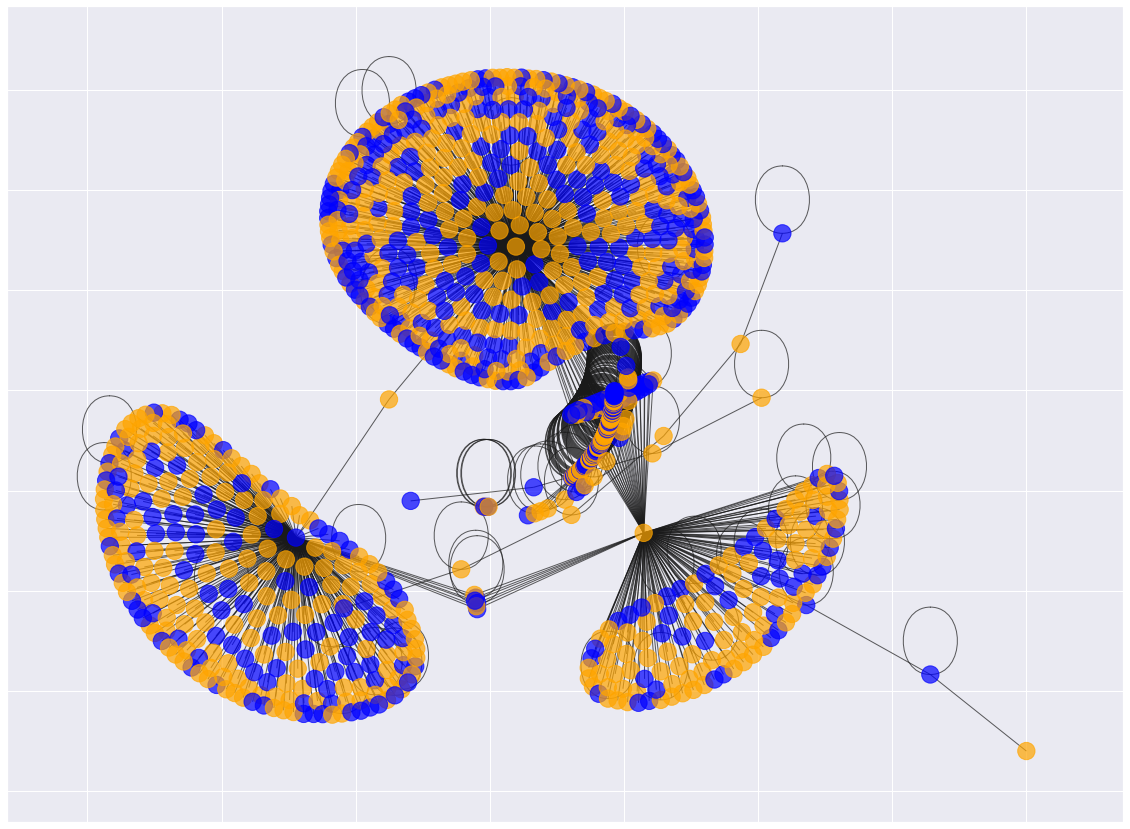

In [71]:
# creating the visualisation of the network
fig2=plt.figure(figsize=(20,15))

G = nx.Graph()
G.add_edges_from(graph.edges())
G.add_nodes_from(graph.nodes())

pos = nx.layout.kamada_kawai_layout(G)

nx.draw_networkx(G, pos=pos, alpha=0.7,
                 cmap='coolwarm', node_color = nodes['colours'], with_labels=False)

plt.show()